In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.feature_extraction import image
from sklearn.manifold import TSNE

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
path2csv = './SCUT-FBP5500_v2/All_Ratings.xlsx'
df = pd.read_excel(path2csv)
df.tail()

,Rater,Filename,Rating,original Rating
329995,60,AM995.jpg,2,NaN
329996,60,AM996.jpg,2,NaN
329997,60,AM997.jpg,3,NaN
329998,60,AM998.jpg,3,NaN
329999,60,AM999.jpg,2,NaN


In [3]:
x_train = df[df['Filename'].str.contains('AF')]
cond = x_train['Rater'] == 1
x_train = x_train[cond]
x_train.reset_index(inplace=True, drop=True)
x_train

,Rater,Filename,Rating,original Rating
0,1,AF1.jpg,2,NaN
1,1,AF10.jpg,4,NaN
2,1,AF100.jpg,3,NaN
3,1,AF1000.jpg,4,NaN
4,1,AF1001.jpg,5,NaN
...,...,...,...,...
1995,1,AF995.jpg,3,NaN
1996,1,AF996.jpg,3,NaN
1997,1,AF997.jpg,4,NaN
1998,1,AF998.jpg,3,NaN


In [4]:
img_name = list(x_train.iloc[:,1])
img_name[:3]

['AF1.jpg', 'AF10.jpg', 'AF100.jpg']

In [5]:
data = []

for filename in tqdm(img_name):
    image = cv2.imread("./SCUT-FBP5500_v2/Images/"+filename)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, "./SCUT-FBP5500_v2/Images/"+filename])

100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 506.56it/s]


In [6]:
features, images  = zip(*data)

In [7]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [8]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [9]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=300, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 736.233684
[t-SNE] Computed conditional probabilities in 0.153s
[t-SNE] Iteration 50: error = 76.1237869, gradient norm = 0.2015786 (50 iterations in 1.483s)
[t-SNE] Iteration 100: error = 76.5156631, gradient norm = 0.2003076 (50 iterations in 1.412s)
[t-SNE] Iteration 150: error = 76.2634811, gradient norm = 0.1889412 (50 iterations in 1.359s)
[t-SNE] Iteration 200: error = 76.4102325, gradient norm = 0.1924392 (50 iterations in 1.399s)
[t-SNE] Iteration 250: error = 76.0048294, gradient norm = 0.1905943 (50 iterations in 1.373s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.004829
[t-SNE] Iteration 300: error = 1.6810929, gradient norm = 0.0011807 (50 iterations in 1.340

In [10]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

## Plots the clusters

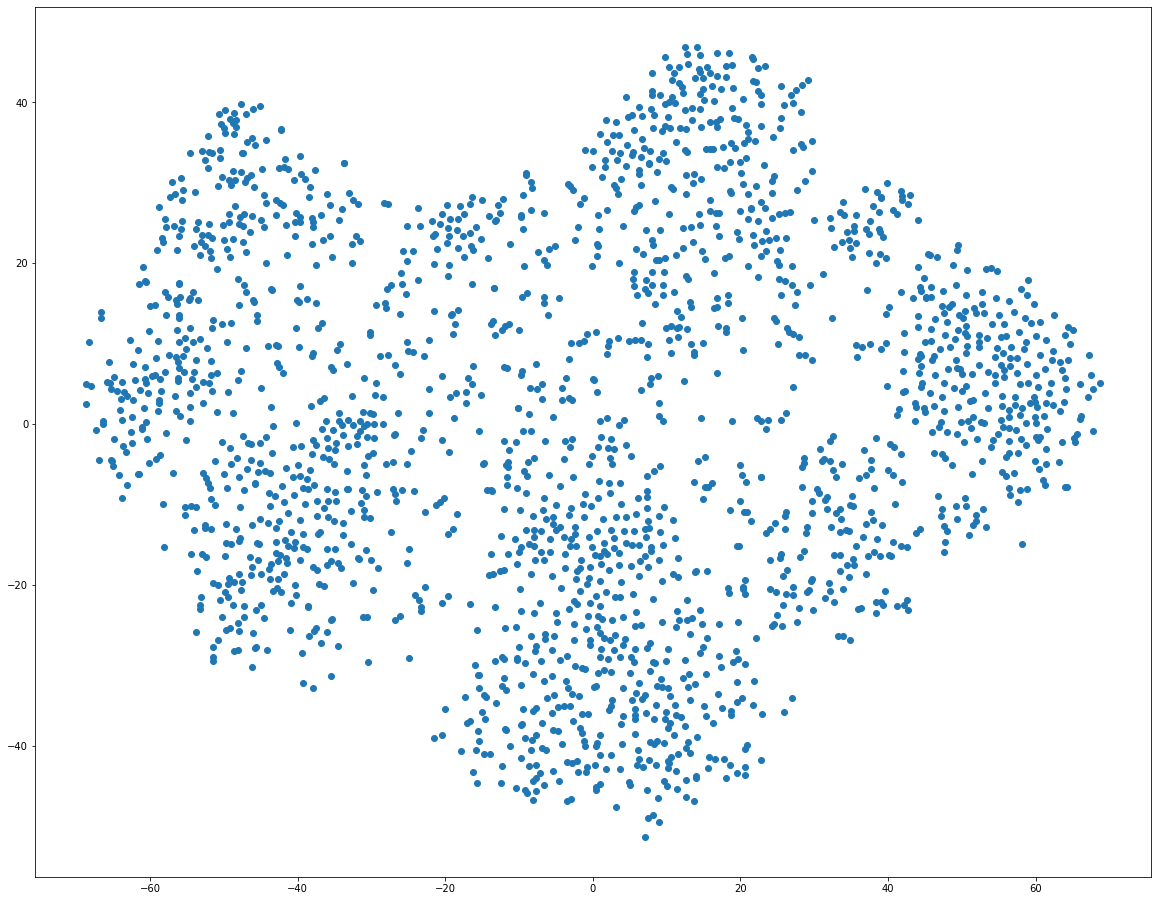

In [11]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow
from PIL import Image

plt.rcParams['figure.figsize'] = [20, 16]
xs = tsne[:,0]
ys = tsne[:,1]
plt.scatter(xs,ys)
plt.show()

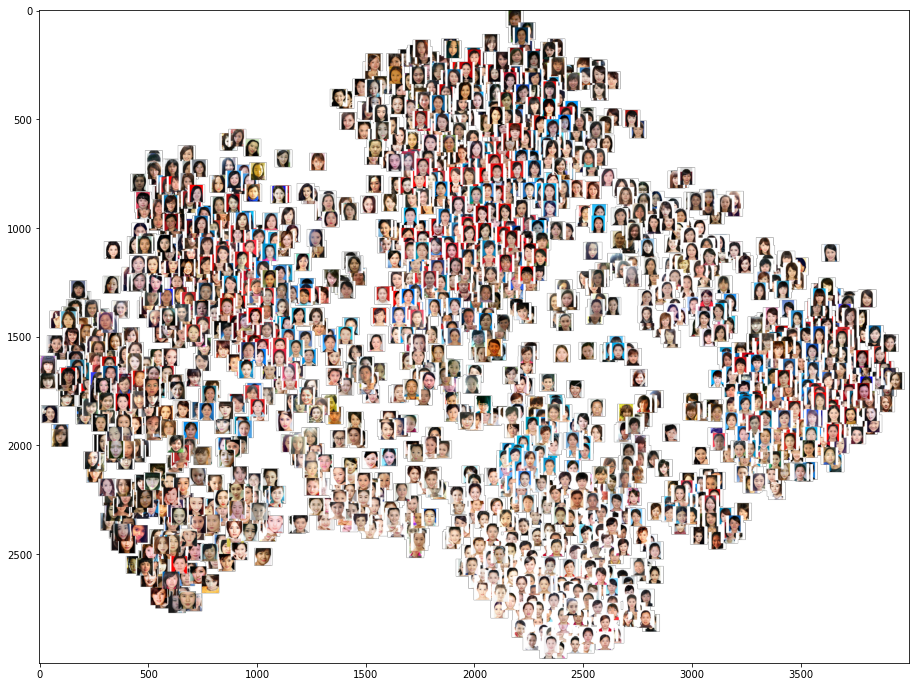

In [12]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    tile = tile.resize((int(tile.width*0.8), int(tile.height*0.8)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [13]:
# save json, png
"""
import os
import json

full_image.save("../data/test_tSNE.png")

tsne_path = "../data/test_tSNE.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)"""

'\nimport os\nimport json\n\nfull_image.save("../data/test_tSNE.png")\n\ntsne_path = "../data/test_tSNE.json"\n\ndata = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]\nwith open(tsne_path, \'w\') as outfile:\n    json.dump(data, outfile)\n\nprint("saved t-SNE result to %s" % tsne_path)'

## DBSCAN

In [14]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2.4, min_samples=6)
predict = model.fit(tsne)
pd.Series(predict.labels_).value_counts()

-1     468
 0     296
 5     205
 3     203
 6     121
 1      99
 7      59
 14     47
 2      42
 4      40
 20     40
 17     37
 25     24
 16     19
 29     16
 11     16
 38     16
 22     16
 30     14
 10     13
 13     11
 9      10
 27     10
 31     10
 8      10
 36      9
 46      9
 18      8
 19      8
 37      8
 24      8
 23      8
 39      7
 35      7
 26      7
 15      7
 21      7
 47      6
 12      6
 44      6
 41      6
 45      6
 28      6
 43      6
 34      6
 42      6
 40      6
 33      4
 32      1
dtype: int64